In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/classificados_separados.json')

Mounted at /content/drive


In [ ]:
def distance_between(p1,p2):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    distance = int(math.sqrt( dx**2 + dy**2 ))
    return distance

def angle_between(p1,p2):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    
    angle = 0
    if p2[0] != p1[0]:
        angle= round((math.atan2(dx, dy)*180)/math.pi, 2)
        # if angle>=180 :
        #    angle = angle-180
        if angle<0 :
           angle = -(angle)
    if p2[0] == p1[0]:
        angle = 90

    return angle

In [ ]:
DEBUG_CV2 = False
results = []
path = "/content/drive/MyDrive/Colab Notebooks/TCC/dados_brutos/"

import time

inicio = time.time()

def plot_pointers(image, eye_l, eye_r, nose, mouth_l, mouth_r):
  image = cv2.circle(image, eye_l, 2, (255, 0, 0), 1)
  image = cv2.circle(image, eye_r, 2, (0, 255, 0), 1)
  image = cv2.circle(image, nose, 2, (0, 0, 255), 1)
  image = cv2.circle(image, mouth_l, 2, (255, 255, 0), 1)
  image = cv2.circle(image, mouth_r, 2, (0, 255, 255), 1)


################################################################################
# Algoritmo de detecção
################################################################################
def detect(angle_nose_mouth_l, angle_nose_mouth_r, angle_eye_l_mouth_l):
  if (angle_nose_mouth_l < 25) or (angle_nose_mouth_r < 25):
    return False
  elif (angle_nose_mouth_l < 30) and (angle_nose_mouth_r < 30):
    return False
  elif (angle_eye_l_mouth_l > 10) and (angle_eye_l_mouth_l < 80):
    return False
  else: 
    return True 

  # if (angle_nose_mouth_l < 25) and (angle_nose_mouth_r < 55):
  #   return False
  # elif (angle_nose_mouth_r < 25) and (angle_nose_mouth_l < 55):
  #   return False
  # else:
  #   return True

### Criando as colunas pra montar o dataset que o Yuri pediu
df['dist_nose_mouth_l'] = None 
df['angle_nose_mouth_l'] = None 
df['dist_nose_mouth_r'] = None 
df['angle_nose_mouth_r'] = None 
df['dist_between_mouth'] = None 
df['angle_between_mouth'] = None
df['dist_eye_l_mouth_l'] = None 
df['angle_eye_l_mouth_l'] = None

test = []
predict = []
for c in range(0,df.shape[0]):
  row = df.loc[c]

  # for c in range(0, df.shape[0]): #df.shape[0]
  eye_l = (row['eye_l_x'], row['eye_l_y'])
  eye_r = (row['eye_r_x'], row['eye_r_y'])
  nose = (row['nose_x'], row['nose_y'])
  mouth_l = (row['mouth_l_x'], row['mouth_l_y'])
  mouth_r = (row['mouth_r_x'], row['mouth_r_y'])
  box_init = (row['box1'], row['box2'])
  box_end =  (row['box3'], row['box4'])
  img = row['img'] 
  
  # print("[eye_l, eye_r]", distance_between(eye_l,eye_r) , angle_between(eye_l,eye_r))
  # print("[mouth_l, mouth_r]", distance_between(mouth_l, mouth_r), angle_between(mouth_l, mouth_r))
  # print("[nose, eye_l]", distance_between( nose, eye_l) , angle_between( nose, eye_l))
  # print("INIT ---------------------")
  
  dist_nose_mouth_l, angle_nose_mouth_l = distance_between(nose, mouth_l) , angle_between(nose, mouth_l)
  dist_nose_mouth_r, angle_nose_mouth_r = distance_between(nose, mouth_r) , angle_between(nose, mouth_r)
  dist_between_mouth, angle_between_mouth = distance_between(mouth_l, mouth_r) , angle_between(mouth_l, mouth_r)
  dist_eye_l_mouth_l, angle_eye_l_mouth_l = distance_between(eye_l, mouth_l) , angle_between(eye_l, mouth_l)
  detected = detect( angle_nose_mouth_l, angle_nose_mouth_r, angle_eye_l_mouth_l)

  ## Acurácia
  test.append(row['result'])
  predict.append(detected)

  ## Remover para exibir tudo, senão mostrará apenas os errados.
  # if (line['result'] == detected): 
    # continue

  ### @pending ver para adicionar ao dataframe
  df['dist_nose_mouth_l'][c] = dist_nose_mouth_l 
  df['angle_nose_mouth_l'][c] = angle_nose_mouth_l 
  df['dist_nose_mouth_r'][c] = dist_nose_mouth_r 
  df['angle_nose_mouth_r'][c] = angle_nose_mouth_r 
  df['dist_between_mouth'][c] = dist_between_mouth 
  df['angle_between_mouth'][c] = angle_between_mouth
  df['dist_eye_l_mouth_l'][c] = dist_eye_l_mouth_l 
  df['angle_eye_l_mouth_l'][c] = angle_eye_l_mouth_l
  # print("Result:", row['result'], detected )

  if DEBUG_CV2:
    image = cv2.imread(path + img)
    if (row['result'] == True):
      image = cv2.rectangle(image, box_init, box_end, (255, 0, 0), 1)
    else:
      image = cv2.rectangle(image, box_init, box_end, (0, 0, 255), 1)
    
    plot_pointers(image, eye_l, eye_r, nose, mouth_l, mouth_r)
    # image = cv2.line(image, eye_l, eye_r,  (255, 255, 255), 1)
    image = cv2.line(image, mouth_l, mouth_r,  (255, 255, 255), 1)
    # image = cv2.line(image, nose, eye_l,  (255, 0, 0), 1)
    # image = cv2.line(image, nose, eye_r,  (0, 255, 0), 1)
    image = cv2.line(image, nose, mouth_l,  (0, 0, 255), 1)
    image = cv2.line(image, nose, mouth_r,  (0, 255, 255), 1)
    image = cv2.line(image, eye_l, mouth_l,  (255, 200, 150), 1)
    cv2_imshow(image)

from sklearn.metrics import accuracy_score
acc = accuracy_score(test, predict)
fim = (time.time() - inicio)
print("--->", acc, "time:", fim)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to b

---> 0.8018867924528302 time: 0.3972129821777344


In [ ]:
df.head()

,eye_l_x,eye_l_y,img,mouth_r_y,eye_r_x,eye_r_y,mouth_r_x,mouth_l_y,mouth_l_x,result,...,box3,box2,dist_nose_mouth_l,angle_nose_mouth_l,dist_nose_mouth_r,angle_nose_mouth_r,dist_between_mouth,angle_between_mouth,dist_eye_l_mouth_l,angle_eye_l_mouth_l
0,145,114,i65304011.jpg,151,184,114,180,150,147,True,...,210,71,26,37.3,27,37.69,33,88.26,36,3.18
1,149,112,i65939017.jpg,149,193,112,188,149,152,True,...,221,65,30,31.61,32,37.57,36,90.0,37,4.64
2,147,115,i58079774.jpg,150,185,116,181,149,149,True,...,207,75,27,37.69,27,33.11,32,88.21,34,3.37
3,143,111,i69338781.jpg,152,187,112,183,151,144,True,...,222,71,29,42.27,29,39.56,39,88.53,40,1.43
4,143,111,i68846788.jpg,165,189,116,182,160,143,True,...,214,72,35,35.91,38,27.9,39,82.69,49,90


## Pre processamento

In [ ]:
df = df.drop(['img', 'box1', 'box2', 'box3', 'box4'], axis=1)

## Separa em dados de treinamento e teste



In [ ]:
from sklearn.model_selection import train_test_split
# Separar o conjunto de dados entre treino e teste
# 30% para test -> (manda sem a resposta)
y = df['result']
x = df.drop(['result'], axis=1)

df_origin_x = x.copy()
df_origin_y = y.copy()

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.30, random_state=1)

x

,eye_l_x,eye_l_y,mouth_r_y,eye_r_x,eye_r_y,mouth_r_x,mouth_l_y,mouth_l_x,nose_x,nose_y,dist_nose_mouth_l,angle_nose_mouth_l,dist_nose_mouth_r,angle_nose_mouth_r,dist_between_mouth,angle_between_mouth,dist_eye_l_mouth_l,angle_eye_l_mouth_l
0,145,114,151,184,114,180,150,147,163,129,26,37.3,27,37.69,33,88.26,36,3.18
1,149,112,149,193,112,188,149,152,168,123,30,31.61,32,37.57,36,90.0,37,4.64
2,147,115,150,185,116,181,149,149,166,127,27,37.69,27,33.11,32,88.21,34,3.37
3,143,111,152,187,112,183,151,144,164,129,29,42.27,29,39.56,39,88.53,40,1.43
4,143,111,165,189,116,182,160,143,164,131,35,35.91,38,27.9,39,82.69,49,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,163,112,149,199,114,194,147,162,183,126,29,45.0,25,25.56,32,86.42,35,1.64
102,173,114,146,201,114,203,147,178,195,129,24,43.36,18,25.2,25,92.29,33,8.62
103,198,109,140,222,111,220,139,198,219,122,27,51.01,18,3.18,22,87.4,30,90
104,209,118,158,234,118,234,158,213,236,139,29,50.44,19,6.01,21,90.0,40,5.71


NAIVE BAYER

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

import time

inicio = time.time()

clf_naive_bayer = GaussianNB()
clf_naive_bayer.fit(xtrain, ytrain)
ypredict = clf_naive_bayer.predict(xtest)
acc = accuracy_score(ytest, ypredict)

print("--->", acc, "time:", time.time() - inicio)

---> 0.96875 time: 0.01064610481262207


REDES NEURAIS

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(activation ='relu' , solver='adam', max_iter=100)
mlp.fit(xtrain,ytrain)
ypredict = mlp.predict(xtest)
acc = accuracy_score(ytest, ypredict)
print("--->", acc)

---> 0.75


SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parametersSVC = {
    'C': [0.1 , 1, 10],
    'kernel': ['poly']
}
modelSVC = SVC()
gridSearch = GridSearchCV(estimator=modelSVC, param_grid = parametersSVC, cv=5, scoring = 'accuracy', verbose=1)
gridSearch.fit(xtrain, ytrain)

print(gridSearch.best_score_)
print(gridSearch.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.9190476190476191
SVC(C=10, kernel='poly')


# Automatização da seleção do melhor modelo

Foram escolhidos os 3 melhores para aplicar nesta etapa de automatização:

Arvore de decisão
Regressão logistica
SVM

In [ ]:
# Importando as bibliotecas dos modelos e o Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB # https://scikit-learn.org/
from sklearn.tree import DecisionTreeClassifier
pipe = Pipeline(steps= [('classifier', SVC())])

search_space = [
    {'classifier': [SVC()], 'classifier__kernel': ['poly']},
    {'classifier': [LogisticRegression(max_iter = 1000, random_state = 5)]},
    {'classifier': [DecisionTreeClassifier(random_state=5)]}
]

grid_model = GridSearchCV(estimator= pipe, 
                          param_grid = search_space,
                          scoring= 'accuracy',
                          cv=5, 
                          verbose=1)

models = grid_model.fit(xtrain, ytrain)

print(models.best_score_)
print(models.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.9199999999999999
Pipeline(steps=[('classifier',
                 LogisticRegression(max_iter=1000, random_state=5))])


Verdadeiro Negativo ---> 12
Falso Positivo ---> 6
Falso Negativo ---> 2
Verdadeiro Positivo ---> 12


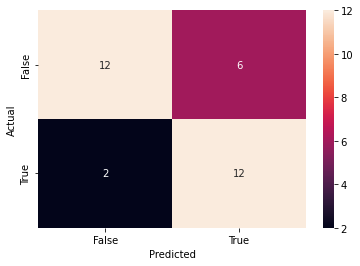

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

confusion = pd.crosstab(ytest, ypredict, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion, annot=True)

tn, fp, fn, tp = confusion_matrix(ytest,ypredict).ravel()

print('Verdadeiro Negativo --->', tn)
print('Falso Positivo --->', fp)
print('Falso Negativo --->', fn)
print('Verdadeiro Positivo --->', tp)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

acc = accuracy_score(ytest, ypredict)
pre = precision_score(ytest, ypredict)
rec = recall_score(ytest, ypredict)

f1score = f1_score(ytest, ypredict)

print("Acurácia --->", acc)
print("Precisão --->", pre)
print("Recall Score --->", rec)
print("F1 Score --->", f1score)

Acurácia ---> 0.75
Precisão ---> 0.6666666666666666
Recall Score ---> 0.8571428571428571
F1 Score ---> 0.75


# Arvore de decisão

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier;
from sklearn import metrics;

y = df_origin_y
x = df_origin_x

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.30, random_state=1)

In [ ]:
#Função para executar a classificação  
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth= 5);
clf = clf.fit(xtrain, ytrain);
#Precição do test
ypred = clf.predict(xtest);

#Accuracy considerada boa: 85% - 95%
print("Accuracy:" , metrics.accuracy_score(ytest,ypred));

Accuracy: 0.875


In [ ]:

from sklearn.tree import export_graphviz;
from six import StringIO

# from sklearn.externals.six import StringIO;
from IPython.display import Image;
import pydotplus;

colunas = []
for col_name in df.columns: 
  colunas.append(col_name)

df.head()


,eye_l_x,eye_l_y,mouth_r_y,eye_r_x,eye_r_y,mouth_r_x,mouth_l_y,mouth_l_x,result,nose_x,nose_y,dist_nose_mouth_l,angle_nose_mouth_l,dist_nose_mouth_r,angle_nose_mouth_r,dist_between_mouth,angle_between_mouth,dist_eye_l_mouth_l,angle_eye_l_mouth_l
0,145,114,151,184,114,180,150,147,True,163,129,26,37.3,27,37.69,33,88.26,36,3.18
1,149,112,149,193,112,188,149,152,True,168,123,30,31.61,32,37.57,36,90.0,37,4.64
2,147,115,150,185,116,181,149,149,True,166,127,27,37.69,27,33.11,32,88.21,34,3.37
3,143,111,152,187,112,183,151,144,True,164,129,29,42.27,29,39.56,39,88.53,40,1.43
4,143,111,165,189,116,182,160,143,True,164,131,35,35.91,38,27.9,39,82.69,49,90


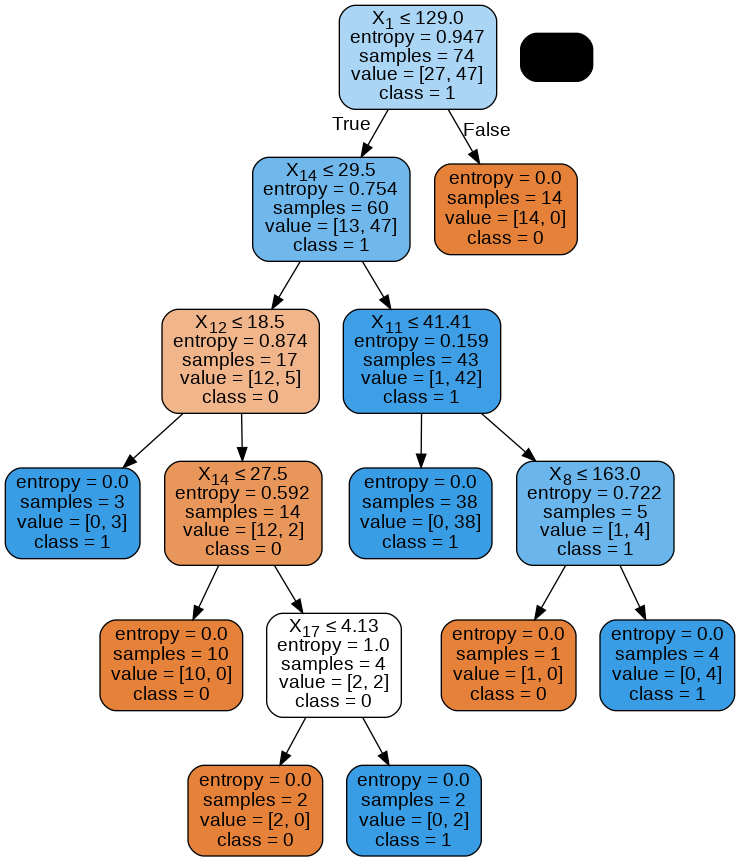

In [ ]:

dot_data = StringIO();
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True,special_characters=True, feature_names=None, class_names=['0','1']);
graph = pydotplus.graph_from_dot_data(dot_data.getvalue());
graph.write_png('death.png');
Image(graph.create_png())
